# Analyse principale du projet de couche limite

### Importation des modules et des fonctions

- helpers contient les fonctions utilisées dans l'analyse
- data_structure contient les classes de données utiles

In [7]:
from data_structures import *
from helpers import *
import matplotlib.pyplot as plt
import numpy as np
N = 50


### Définition de la fonction pour exécuter les analyses selon les paramètres données

In [8]:
def run_analysis(
    params: Params,
    nx: int | None = None,
    ny: int | None = None
) -> Results:
    """
    Résout le problème stationnaire et construit les champs de résultats.

    La fonction :
    - assemble et résout le système MDF pour la température,
    - reconstruit T(x, y) à partir du vecteur solution,
    - calcule le champ de vitesse U(x, y),
    - évalue les couches limites thermique et de vitesse.

    Parameters
    ----------
    params : Params
        Paramètres physiques et géométriques du problème.
    nx : int, optional
        Nombre de points en x. Si None, utilise params.n.
    ny : int, optional
        Nombre de points en y. Si None, utilise params.n.

    Returns
    -------
    Results
        Objet contenant les champs x_mat, y_mat, T_mat, U_mat et les
        épaisseurs de couches limites (y_limite_T, y_limite_U, etc.).
    """

    # Donne la possibilité de définir nx et ny indépendamment de n
    if nx is None:
        nx = params.n
    if ny is None:
        ny = params.n

    A, B = mdf_assemblage((0, params.L), (-params.H / 2, params.H / 2), nx, ny, params)
    T = np.linalg.solve(A, B)   # T de taille N = nx*ny

    x_mat, y_mat = position((0, params.L), (-params.H / 2, params.H / 2), nx, ny)
    # Reconstruction de la matrice température à partir du vecteur 1D T
    T_mat = vecteur_en_matrice(T, nx, ny)

    # Construction de la matrice vitesse (vx, vy = 0)
    U_mat = np.zeros((ny, nx))
    for i in range(ny):
        for j in range(nx):
            U_mat[i, j] = vitesse(x_mat[i, j], y_mat[i, j], params)[0]

    resultats = Results(x_mat, y_mat, T_mat, U_mat)

    # Calcul et stockage des couches limites (thermique et vitesse, + symétrie)
    resultats.y_limite_T = couches_limites(resultats, params)[0]
    resultats.y_limite_U = couches_limites(resultats, params)[1]
    resultats.y_limite_T_symm = couches_limites(resultats, params)[2]
    resultats.y_limite_U_symm = couches_limites(resultats, params)[3]

    return resultats


### Définition de la fonction pour représenter les résultats des analyses facilement
Les fonctions run_analysis et plot utilisent la classe Results pour se transmettre l'information

In [9]:
def plot(Results: Results, note: str = '') -> None:
    """
    Trace les champs de température et de vitesse ainsi que les couches limites.

    Parameters
    ----------
    Results : Results
        Objet contenant x_mat, y_mat, T_mat, U_mat et les épaisseurs de couches limites.
    note : str, optional
        Texte ajouté aux titres des figures (ex. paramètres ou cas étudié).
    """
    plt.figure(figsize=(12, 5))
    niveaux = 100  # nombre de niveaux de contour
    cf = plt.contourf(Results.x_mat, Results.y_mat, Results.T_mat, levels=niveaux)
    plt.colorbar(cf, label="Température [K]")
    # Couche limite thermique
    ax = plt.gca()
    ax.plot(Results.x_mat[0, :], Results.y_limite_T, 'r--', linewidth=2, label='Couche limite thermique')
    ax.plot(Results.x_mat[0, :], Results.y_limite_T_symm, 'r--', linewidth=2)

    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Température dans la couche limite " + note)
    plt.tight_layout()
    plt.show()

    # Visualisation du champ de vitesse
    plt.figure(figsize=(12, 5))
    cf = plt.contourf(Results.x_mat, Results.y_mat, Results.U_mat, levels=niveaux)
    plt.colorbar(cf, label="Vitesse en x [m/s]")
    # Couche limite visqueuse
    ax = plt.gca()
    ax.plot(Results.x_mat[0, :], Results.y_limite_U, 'c--', linewidth=2, label='Couche limite visqueuse')
    ax.plot(Results.x_mat[0, :], Results.y_limite_U_symm, 'c--', linewidth=2)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Champ de vitesse en x dans la couche limite " + note)
    plt.tight_layout()
    plt.show()


## Analyse principale

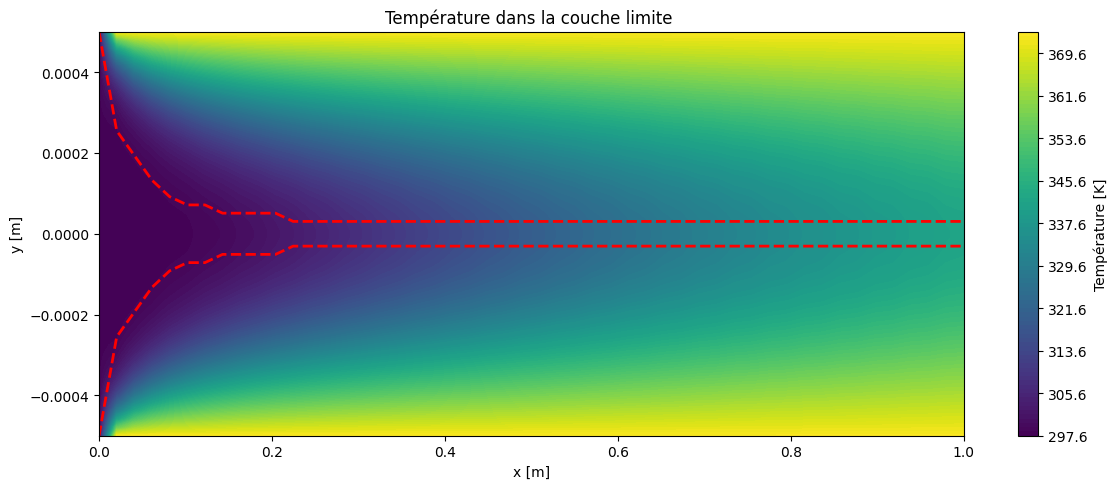

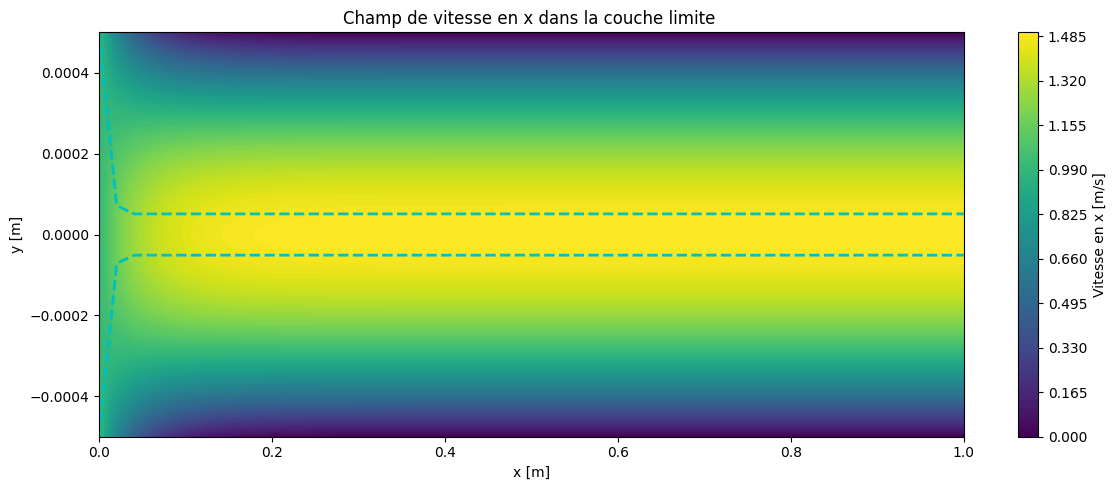

In [10]:
params = Params(
    H = 0.001,
    mu = 0.001,
    rho = 1000,
    T_in = 298,
    T_w = 373,
    cp = 4186,
    k = 0.6,
    L = 1.0,
    U_in = 1.0,
    Ldev = 0.05,
    n=N
)

resultat = run_analysis(params)
plot(resultat)

## Étude de l'influence du nombre de Prandlt, en variant mu

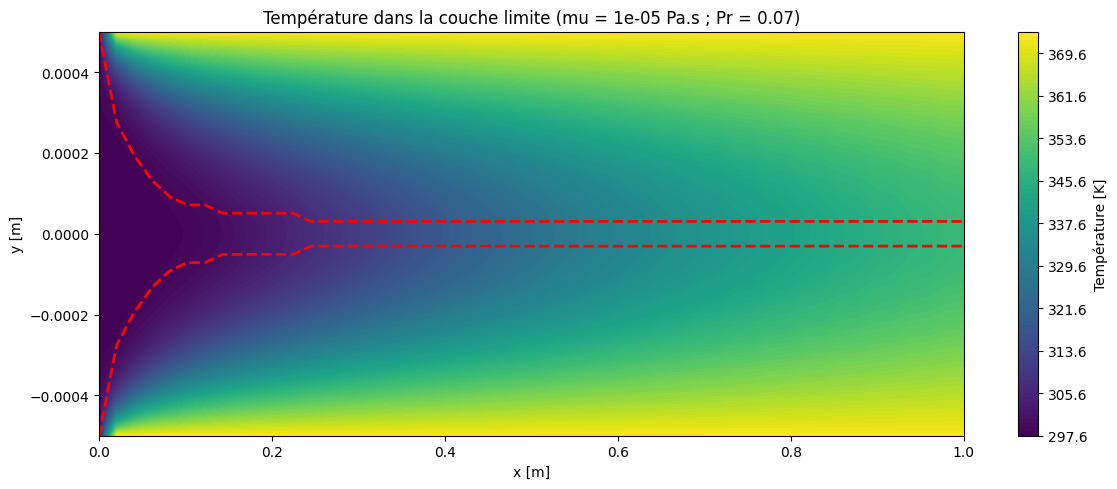

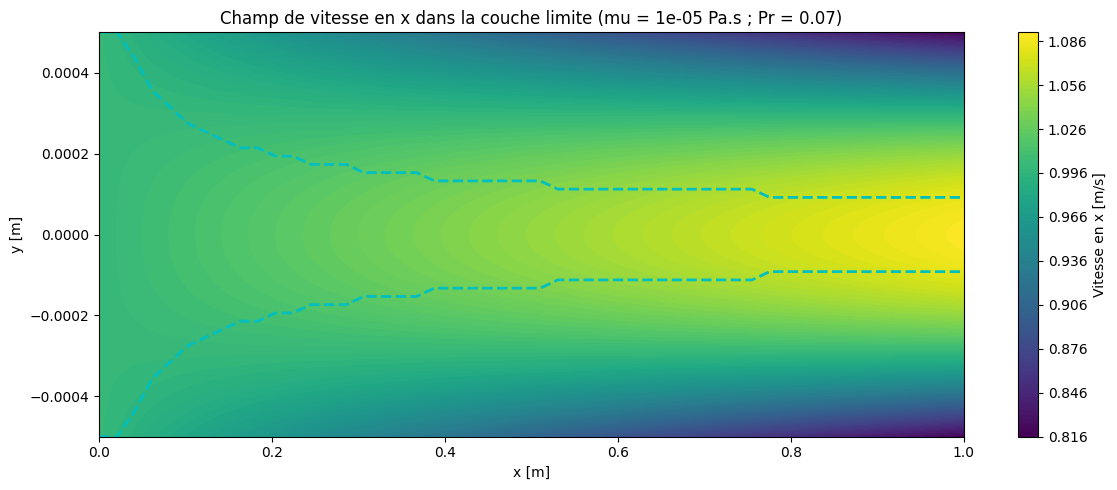

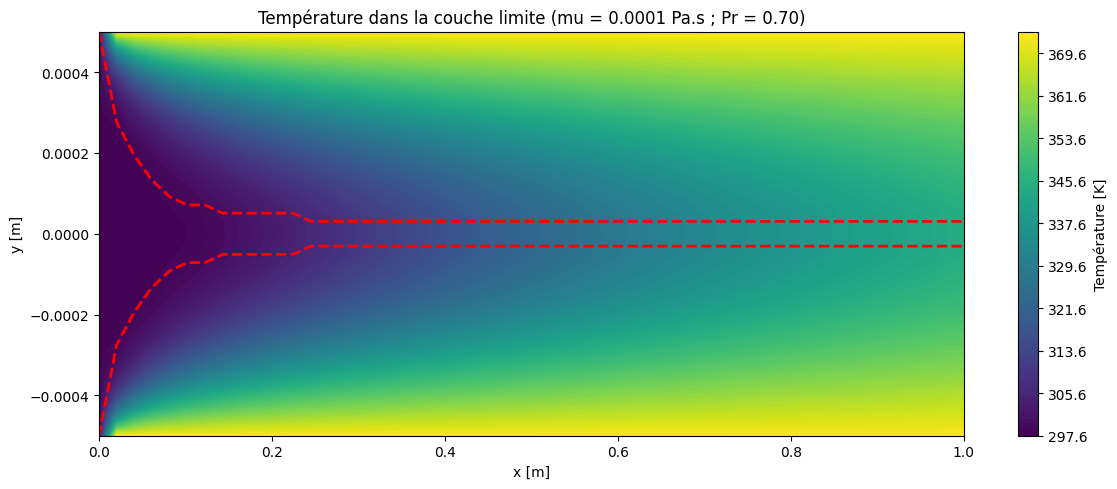

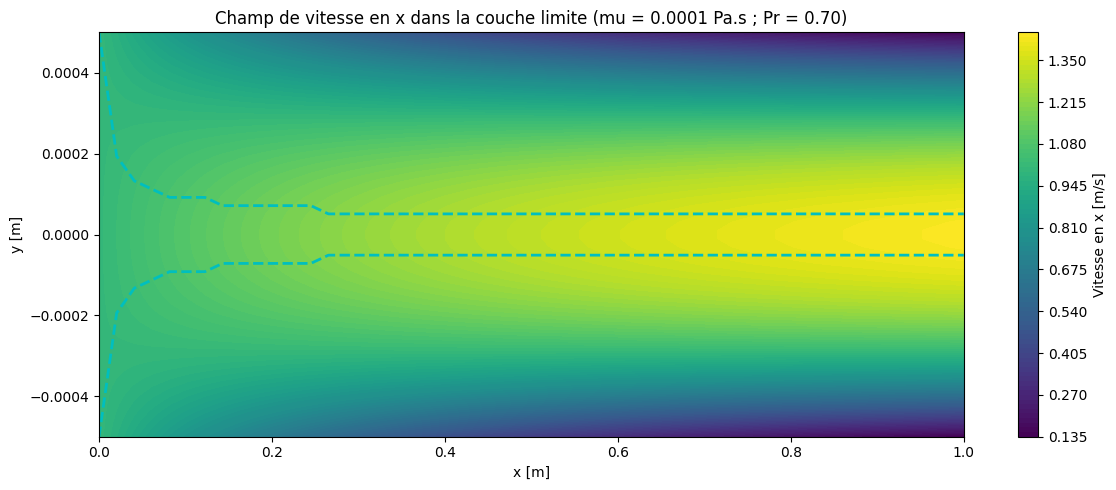

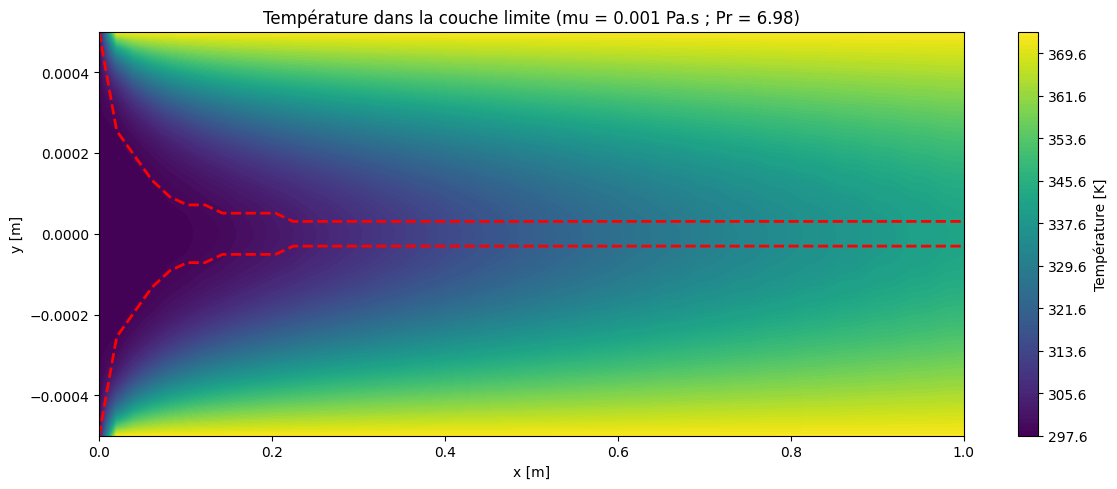

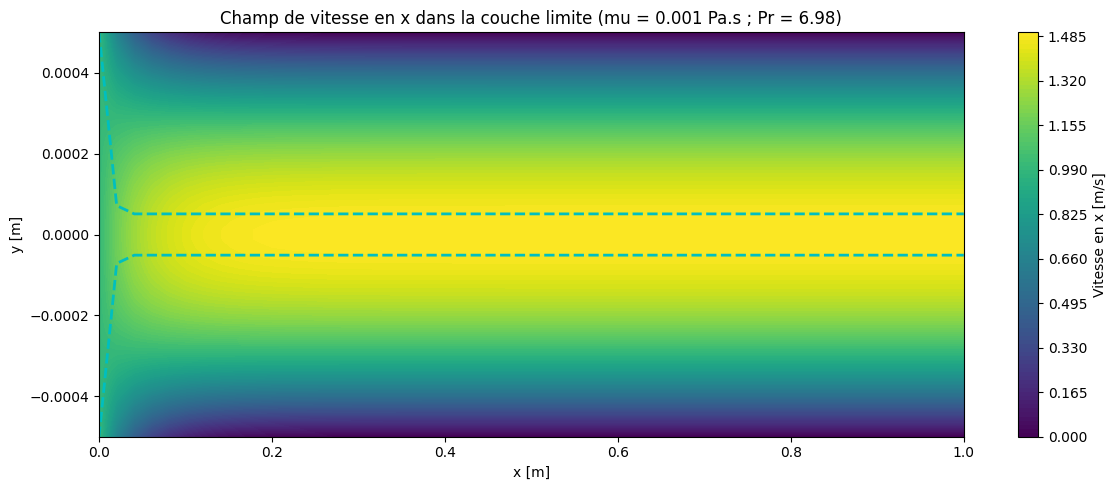

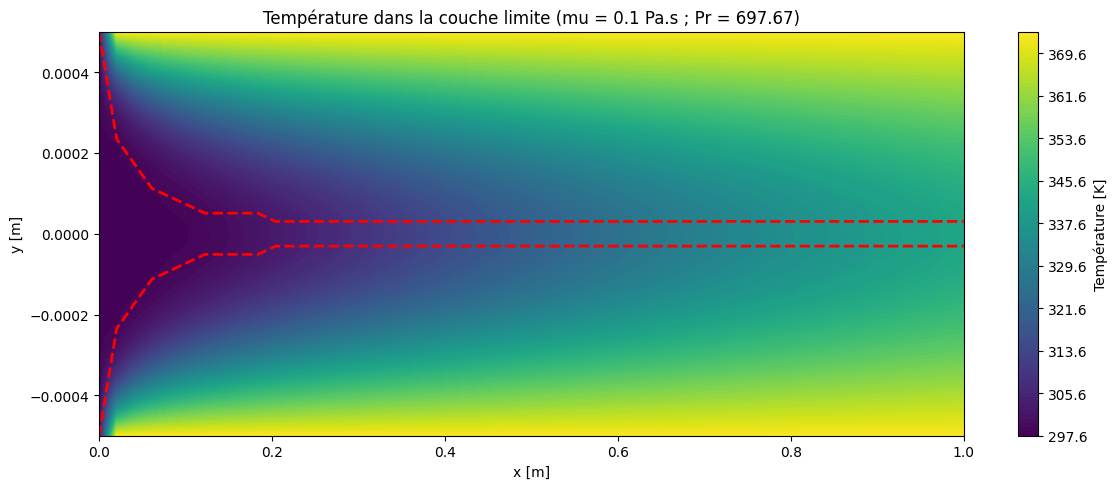

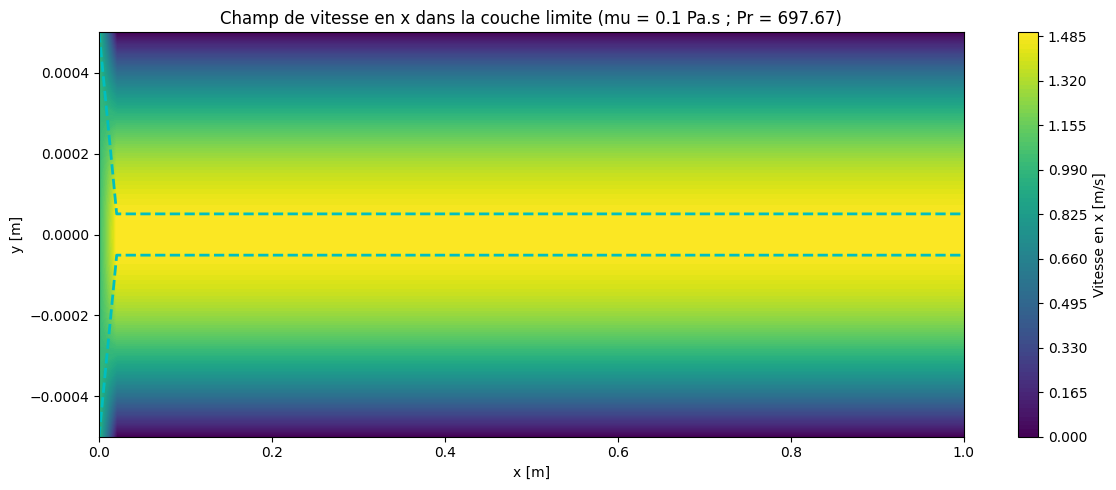

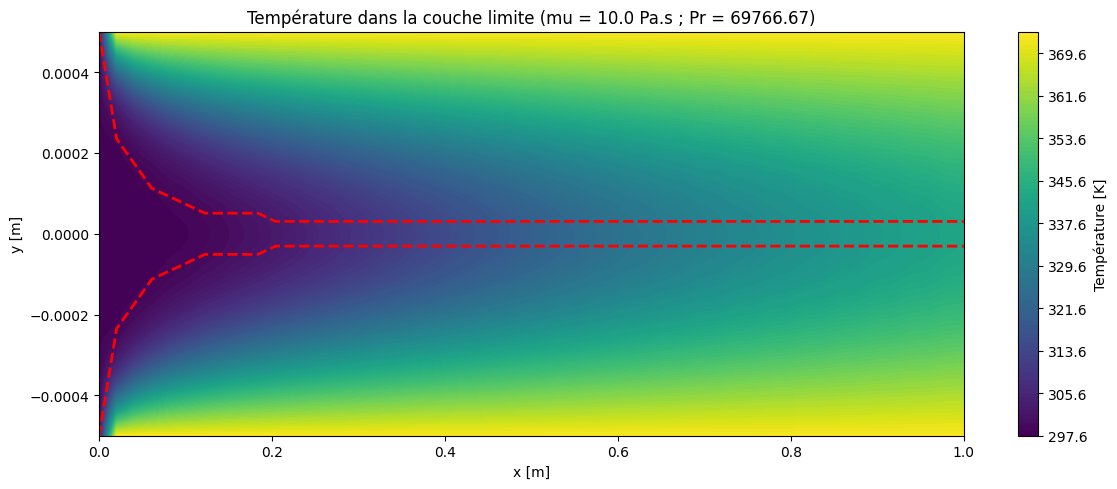

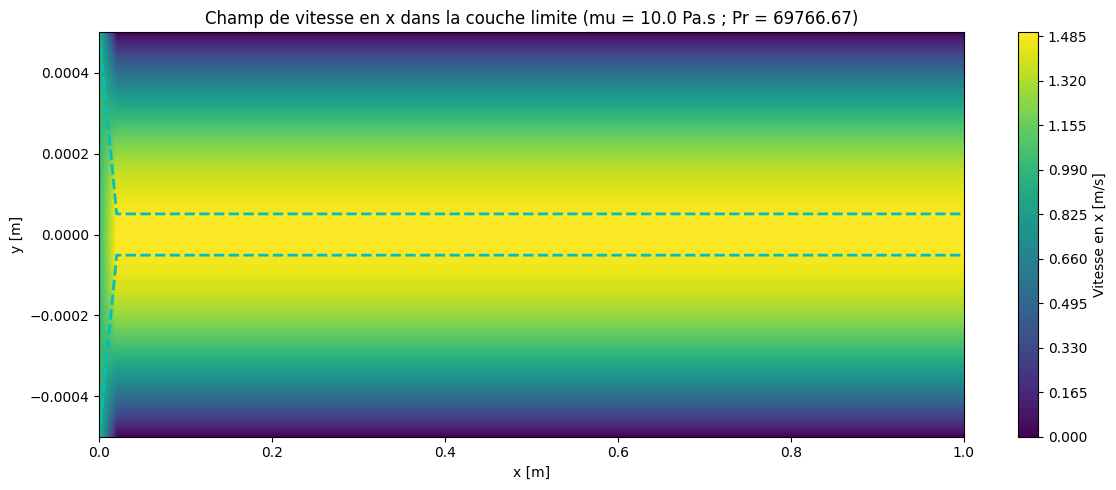

In [11]:
params = Params(
    H = 0.001,
    mu = 0.001,
    rho = 1000,
    T_in = 298,
    T_w = 373,
    cp = 4186,
    k = 0.6,
    L = 1.0,
    U_in = 1.0,
    Ldev = 0.05,
    n = N
)

#Étude de l'influence du nombre de prant
#On choisi de faire varier mu
mu_vals = [0.00001, 0.0001, 0.001, 0.1, 10.0]

for mu in mu_vals:
    params.mu = mu
    
    resultat = run_analysis(params)
    note = f"(mu = {mu} Pa.s ; Pr = {params.cp * mu / params.k:.2f})"
    plot(resultat, note)

## Étude de l'influence du nombre de peclet, en faisant varier U_in

Filtre d'hystérésis activé pour la couche limite thermique (U_in = 0.01 m/s)


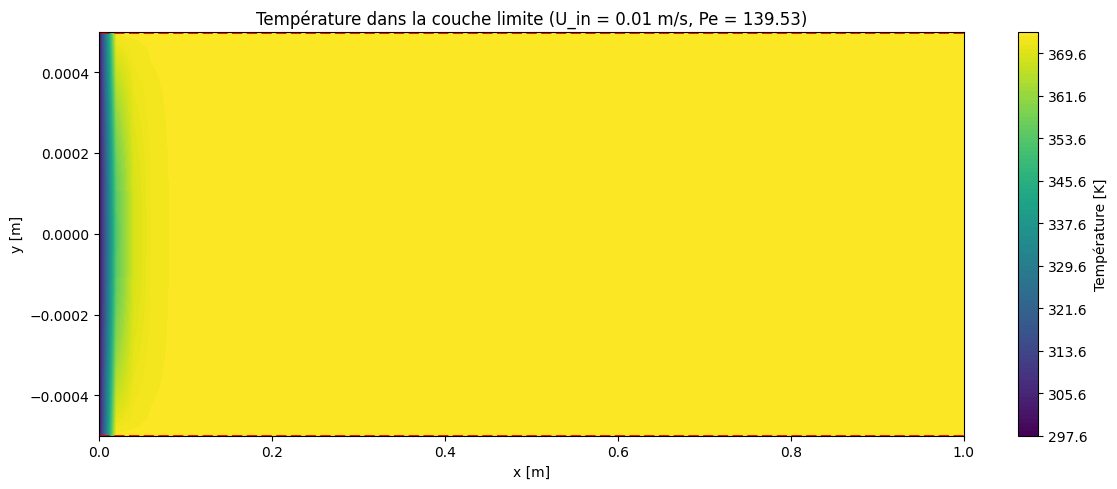

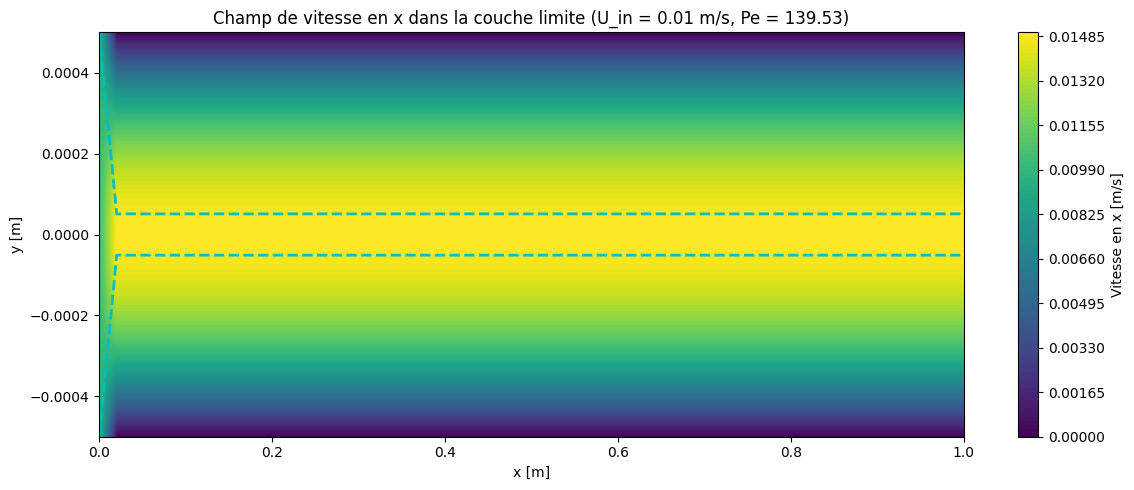

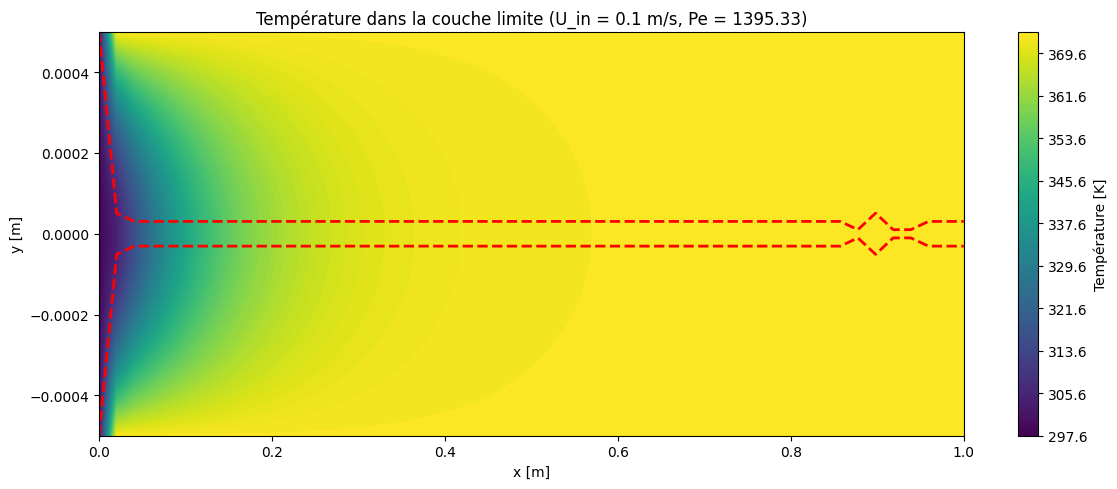

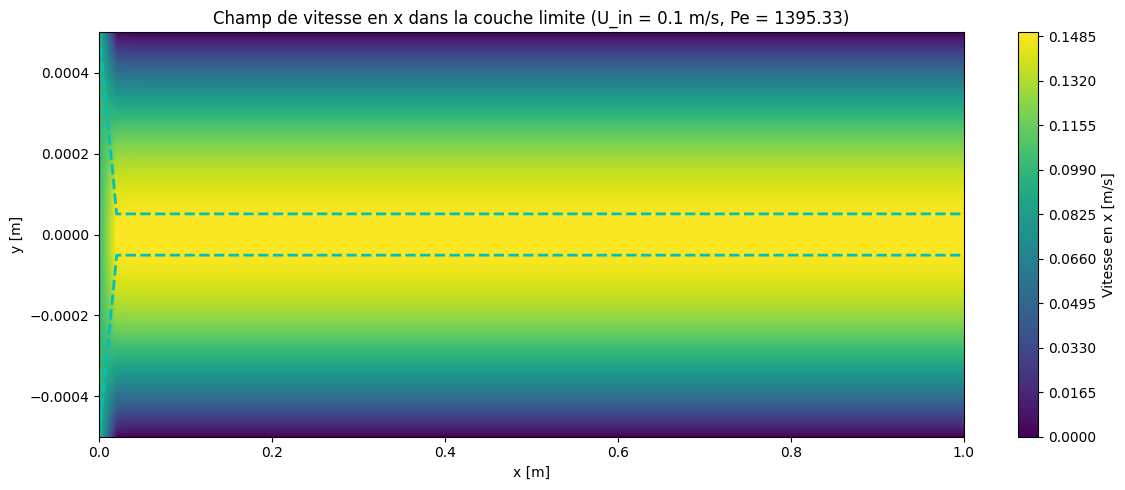

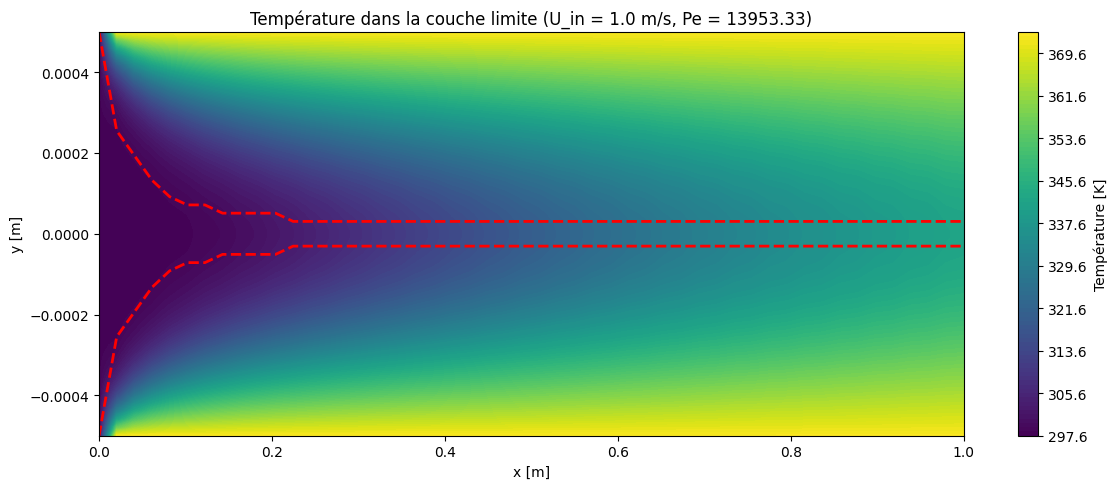

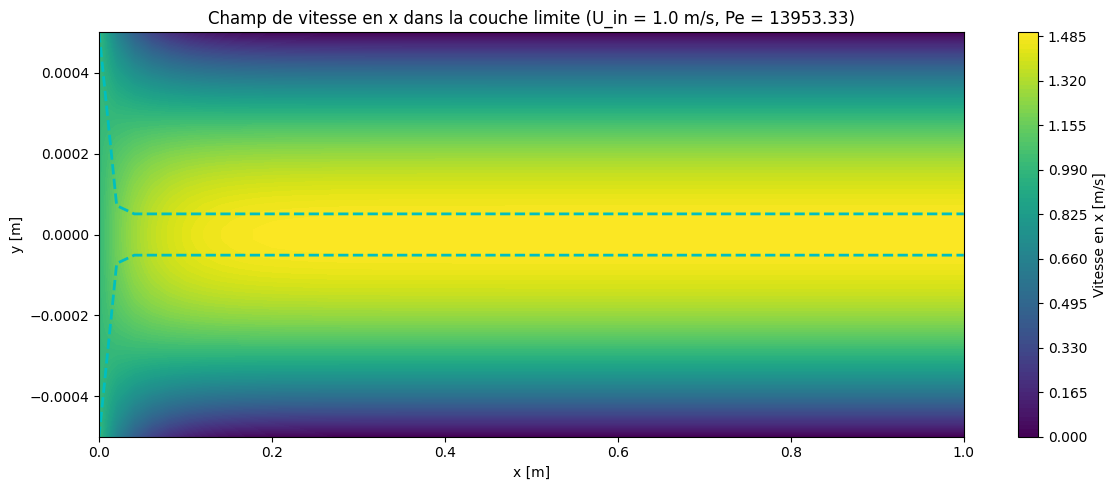

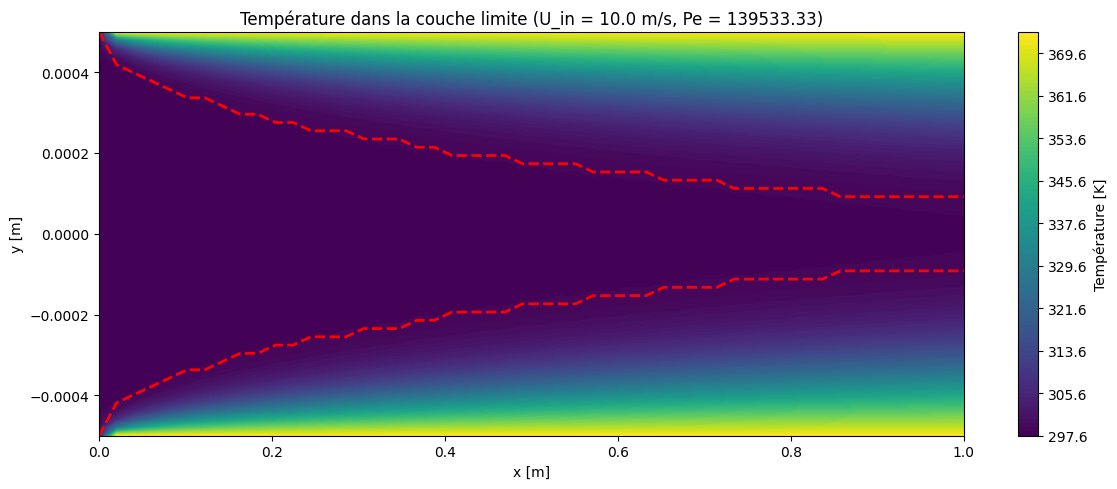

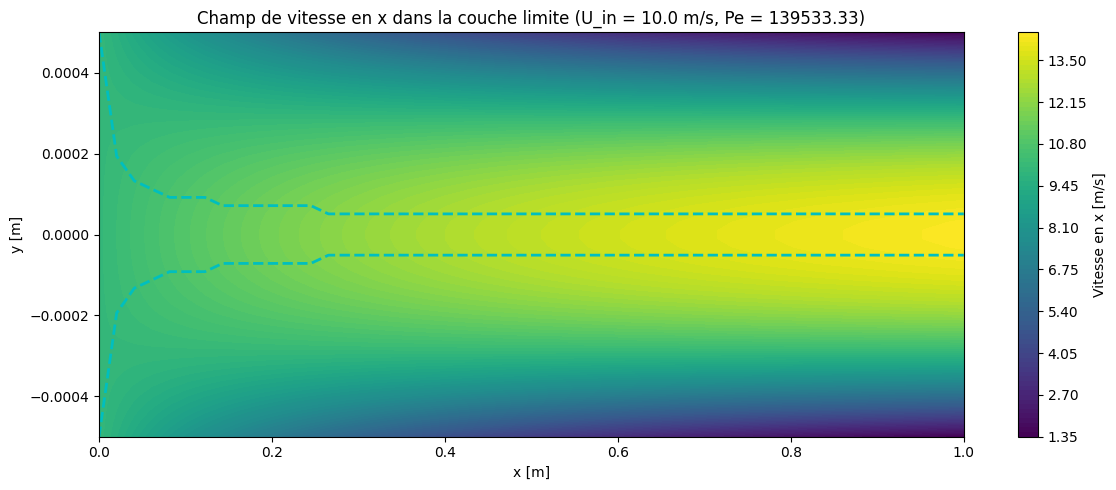

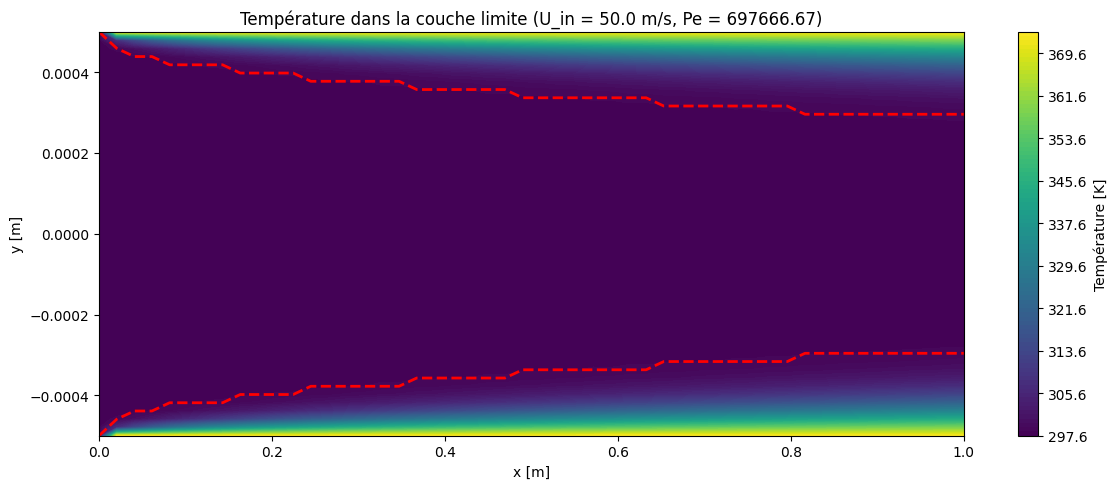

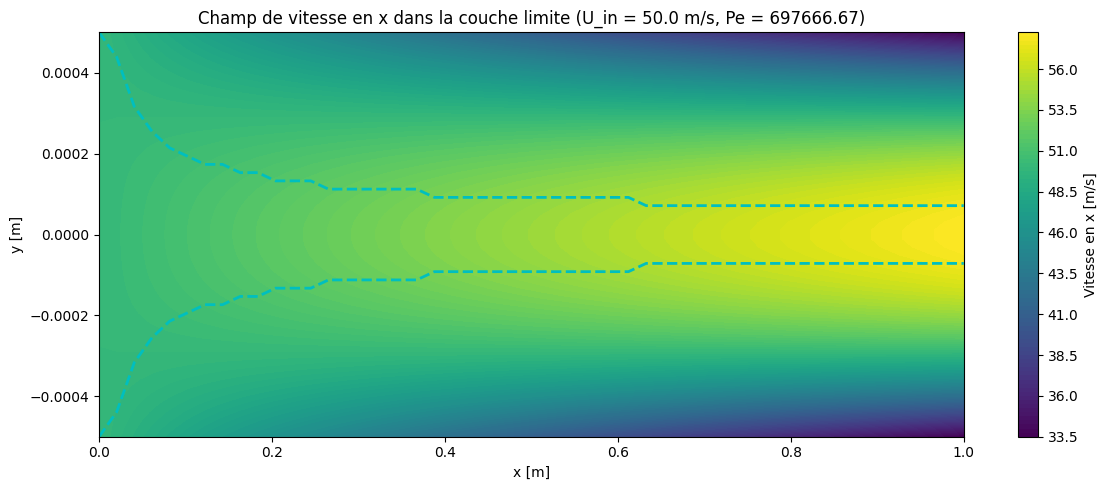

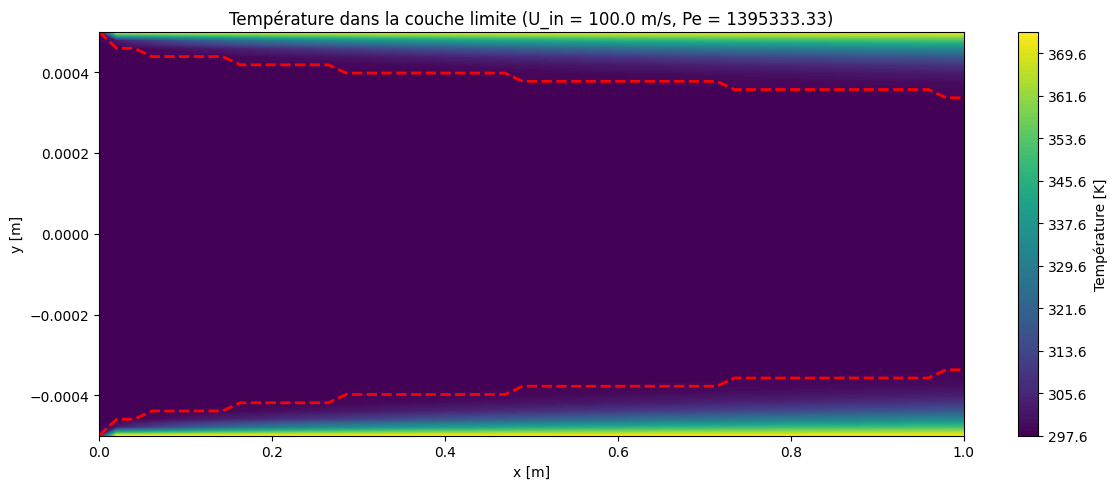

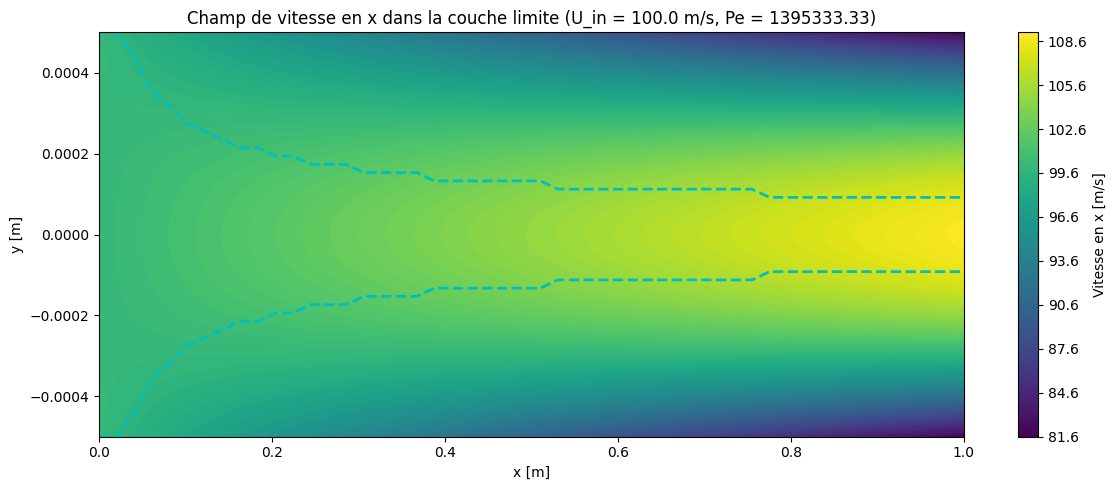

In [12]:
#Étude de l'influence du nombre de peclet
#On choisi de faire varier k
params = Params(
    H = 0.001,
    mu = 0.001,
    rho = 1000,
    T_in = 298,
    T_w = 373,
    cp = 4186,
    k = 0.6,
    L = 1.0,
    U_in = 1.0,
    Ldev = 0.05,
    n = N
)

#Étude de l'influence du nombre de peclet
#On choisi de faire varier U_in
u_vals = [0.01, 0.1, 1.0, 10.0, 50.0, 100.0]

for u in u_vals:
    params.U_in = u
    Pe = 2 * params.rho * params.cp * params.U_in * params.H / params.k
    
    resultat = run_analysis(params)

    # Filtre hystérésis si U_in = 0.01 m/s puisque problème de stabilité numérique
    if abs(params.U_in - 0.01) < 1e-9:


        # Tolérance basée sur le maillage en y
        dy = abs(resultat.y_mat[1, 0] - resultat.y_mat[0, 0])
        epsilon = 2 * dy   # Deux pas de maillage, compromis entre stabilité et précision

        resultat.y_limite_T = filtre_hysteresis(resultat.y_limite_T, epsilon)
        resultat.y_limite_T_symm = filtre_hysteresis(resultat.y_limite_T_symm, epsilon)

        print("Filtre d'hystérésis activé pour la couche limite thermique (U_in = 0.01 m/s)")

    note = f"(U_in = {params.U_in} m/s, Pe = {Pe:.2f})"
    plot(resultat, note)

